<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/MNIST_classification_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [2]:
train_dataset = torchvision.datasets.MNIST(root="data",
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
valid_dataset = torchvision.datasets.MNIST(root="data",
                                           train=False,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 165702339.70it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 100444190.57it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155686177.94it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4896049.54it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



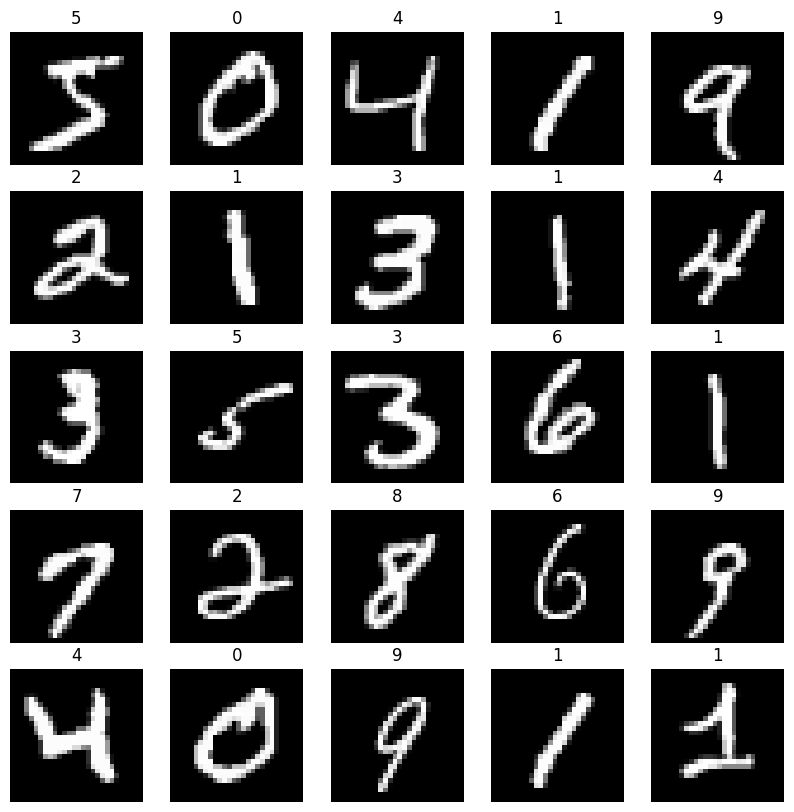

In [3]:
# データを確認
fig, ax = plt.subplots(5,5, figsize=(10,10))

for i in range(25) :
  img, label = train_dataset[i]
  r, c = i//5, i%5
  ax[r, c].imshow(img.squeeze(), cmap="gray")
  ax[r, c].axis("off")
  ax[r, c].set_title(label)

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# class MyModel(nn.Module):
#   def __init__(self, input_size):
#     super(MyModel, self).__init__()
#     self.size = input_size*input_size
#     self.fc1 = nn.Linear(self.size, 1024)
#     self.fc2 = nn.Linear(1024, 256)
#     self.fc3 = nn.Linear(256, 10)
#   def forward(self, x):
#     x = x.view(-1, self.size)
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x

In [5]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.3 MB/s eta 0:00:00


In [17]:
import timm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = timm.create_model('resnet18', num_classes = 10, in_chans = 1).to(device)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
def do_train(model, device, loader, criterion, optimizer):
  model.train()
  tot_loss = 0.0
  tot_score = 0.0
  for images, labels in tqdm(loader, desc="train"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().item()
    tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())

  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [20]:
def do_valid(model, device, loader, criterion):
  model.eval()
  tot_loss = 0.0
  tot_score = 0.0
  with torch.no_grad():
    for images, labels in tqdm(loader, desc="valid"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      tot_loss += loss.detach().item()
      tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())
  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [21]:
num_epochs = 10
for epoch in range(num_epochs):
  print(f'[EPOCH {epoch+1}]')
  train_loss, train_acc = do_train(model, device, train_loader, criterion, optimizer)
  valid_loss, valid_acc = do_valid(model, device, valid_loader, criterion)
  print(f"--> train loss {train_loss}, train accuracy {train_acc}, valid loss {valid_loss} valid accuracy {valid_acc}")

[EPOCH 1]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.12638176585446353, train accuracy 0.9624033848614072, valid loss 0.052790697953577756 valid accuracy 0.9827826433121019
[EPOCH 2]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.05528019047712089, train accuracy 0.9826592484008528, valid loss 0.04878155165648527 valid accuracy 0.9848726114649682
[EPOCH 3]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.04075414743592172, train accuracy 0.9870902185501066, valid loss 0.04151021172240626 valid accuracy 0.9868630573248408
[EPOCH 4]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.034572203353667674, train accuracy 0.9888559434968017, valid loss 0.03915588396152216 valid accuracy 0.9873606687898089
[EPOCH 5]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.027721310297476758, train accuracy 0.9908881929637526, valid loss 0.03804825013597278 valid accuracy 0.9893511146496815
[EPOCH 6]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.023432874316245373, train accuracy 0.9922208155650319, valid loss 0.03538742047616452 valid accuracy 0.988953025477707
[EPOCH 7]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.02118441869417345, train accuracy 0.9932202825159915, valid loss 0.040652631204225756 valid accuracy 0.988156847133758
[EPOCH 8]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.018306856717613097, train accuracy 0.9940531716417911, valid loss 0.040015423946654194 valid accuracy 0.9883558917197452
[EPOCH 9]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.0154414592878947, train accuracy 0.9947694562899787, valid loss 0.0309427944634295 valid accuracy 0.9903463375796179
[EPOCH 10]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.01648723194505562, train accuracy 0.9949360341151386, valid loss 0.031225692634458624 valid accuracy 0.9919386942675159


In [22]:
model.fc3 = nn.Identity()
model.eval()

features = None
classes  = None

for images, labels in tqdm(valid_loader):
  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
  # print(outputs.shape)
  if classes is None:
    classes = labels.cpu()
  else:
    classes = torch.cat((classes, labels.cpu()))

  if features is None:
    features = outputs.cpu()
  else:
    features = torch.cat((features, outputs.cpu()))

  0%|          | 0/157 [00:00<?, ?it/s]

In [23]:
!pip install umap-learn

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


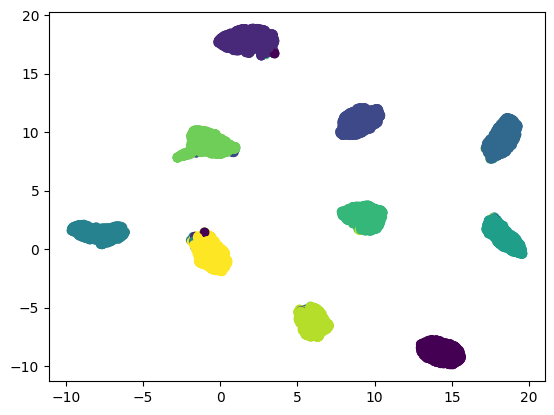

In [24]:
import umap
umap = umap.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(features)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=classes)
plt.show()